In [1]:
import numpy as np
import pandas as pd
from scipy.stats import t
import matplotlib.pyplot as plt
import statsmodels.api as sm
from os.path import exists
import statsmodels.formula.api as smf
from patsy import dmatrix
from scipy.integrate import simps


In [146]:
import matplotlib as mpl

mpl.rc('figure',
       titlesize=24,
       figsize=(12,10),
      dpi=250,
      edgecolor='black',
    facecolor='white'
      )

mpl.rcParams['font.family'] = 'sans-serif' # 'sans-serif' , 'cursive' , 'fantasy','monospace' (e.g., Courier)

mpl.rc('lines',
       linewidth=2,
       color='r',
      linestyle='-',
      markersize=6,
      dash_joinstyle='miter', # miter/round/bevel
      dash_capstyle='butt',  #butt/round/projecting
      solid_joinstyle='miter',
      solid_capstyle='projecting',
      dashed_pattern= (2.8, 1.2),
       dashdot_pattern= (4.8, 1.2, 0.8, 1.2),
       dotted_pattern = (1.1, 1.1),
       scale_dashes = True
      )

mpl.rc('legend',
      fancybox=True, # if True, use a rounded box for the
      numpoints=1, # the number of marker points in the legend line
      markerscale =1,
      fontsize = 'medium',
      borderaxespad = 0.5) # the border between the axes and legend edge
             
mpl.rc('axes',
      facecolor='white',
      edgecolor='black',
      linewidth=1.9,
      grid=False,
      titlesize='large',
      labelsize='large',
      labelcolor='black',
      axisbelow='False') #draw axis gridlines and ticks below, patches (True); above patches but below, lines ('line'); or above all (False) 

mpl.rc('grid',
        color= 'gray',
       linestyle=':',
       linewidth=.8,
       alpha=1.)

mpl.rc('xtick',
      top=True, 
      bottom=True, 
      color ='k',
      labelsize = 'large',
      direction = 'in') 

mpl.rc('xtick.major',
      size=8.,
      width=2.,
      pad=3.5,
      top=True,
      bottom=True)

mpl.rc('xtick.minor',
      size=5.5,
      width=1.5,
      pad=3.4,
      top=True,
      bottom=True)

mpl.rc('ytick',
      right=False, 
      left=True, 
      color ='k',
      labelsize = 'large',
      direction = 'in') 

mpl.rc('ytick.major',
      size=8,
      width=2.,
      pad=3.5,
      left=True,
      right=True)

mpl.rc('ytick.minor',
      size=5.5,
      width=1.5,
      pad=3.4,
      left=True,
      right=True)

# Question 0 -R-Squared Warmup

In [2]:
# tooth growth data
file = './tooth_growth.feather'
if exists(file):
    tg_data = pd.read_feather(file)
else: 
    tooth_growth = sm.datasets.get_rdataset('ToothGrowth')
    #print(tooth_growth.__doc__)
    tg_data = tooth_growth.data
    tg_data.to_feather(file)

tg_data["log_len"] = np.log10(tg_data["len"])
tg_data["supp_cat"] = pd.Categorical(tg_data["supp"])
tg_data['dose_cat'] = pd.Categorical(tg_data['dose'])

In [3]:
mod = sm.OLS.from_formula('log_len ~ dose_cat - supp_cat', data=tg_data)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_len   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     59.47
Date:                Tue, 26 Oct 2021   Prob (F-statistic):           1.12e-14
Time:                        10:26:59   Log-Likelihood:                 40.685
No. Observations:                  60   AIC:                            -75.37
Df Residuals:                      57   BIC:                            -69.09
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.9888      0.028     35.091      0.000       0.932       1.045
dose_cat[T.1.0]     0.2962      0.040      7.432      0.000       0.216       0.376
dose_cat[T.2.0]     0.4235      0.040     10.629      0.000       0.344       0.503
==============================================================================
Omnibus:                        2.984   Durbin-Watson:                   1.225
Prob(Omnibus):                  0.225   Jarque-Bera (JB):                2.588
Skew:                          -0.079   Prob(JB):                        0.274
Kurtosis:                       4.005   Cond. No.                         3.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [4]:
n = tg_data.shape[0]
var = np.var(tg_data.log_len)
ssr = np.sum((res.fittedvalues-tg_data.log_len)**2)/(n)

k = 2 
R2 = 1-(ssr/var)
R_adj = 1 - ((n-1)*(1-R2))/(n-1-k)

print("Calculated R-squared : "+str(R2))
print("statsmodels R-squared: "+str(res.rsquared)+"\n")

print("Calculated Adj R-squared : "+str(R_adj))
print("statsmodels Adj R-squared: "+str(res.rsquared_adj))

Calculated R-squared : 0.6760396871178123
statsmodels R-squared: 0.6760396871178124

Calculated Adj R-squared : 0.6646726585956302
statsmodels Adj R-squared: 0.6646726585956303


# Question 1 - NHANES Dentition

In [164]:
columns_demo = ["SEQN","RIDAGEYR","RIDRETH3","RIAGENDR"]

columns_demo_new = ["id", "age", "race", "gender"]

dtypes = [int, int, int, int]

rename_cols = dict(zip(columns_demo, columns_demo_new))
data_types = dict(zip(columns_demo_new, dtypes))

yr_11_12 = pd.read_sas('./DEMO_G.XPT')[columns_demo]
yr_11_12["period"] =  "2011-2012"
yr_13_14 = pd.read_sas('./DEMO_H.XPT')[columns_demo]
yr_13_14["period"] =  "2013-2014"
yr_15_16 = pd.read_sas('./DEMO_I.XPT')[columns_demo]
yr_15_16["period"] =  "2015-2016"
yr_17_18 = pd.read_sas('./DEMO_J.XPT')[columns_demo]
yr_17_18["period"] =  "2017-2018"

# Stack all the different dataframes into one.
demo_data = pd.concat([yr_11_12, yr_13_14,
                       yr_15_16, yr_17_18],
                      ignore_index=True)

#Change Column Names.
demo_data.rename(columns=rename_cols, inplace=True)
demo_data["gender"] = pd.Categorical(np.where(demo_data.gender > 1.0,"female","male"))

columns_oral = ["SEQN","OHDDESTS"]


#Creating mask forthe required columns
or_11_12 = pd.read_sas('./OHXDEN_G.XPT')
mask1 = or_11_12.columns.str.contains("TC")
mask2 = ((or_11_12.columns=="SEQN") | (or_11_12.columns=="OHDDESTS"))
mask3 = or_11_12.columns.str.contains("CTC")
mask = mask1 | mask2
columns_oral = or_11_12.columns[mask]

or_11_12[columns_oral]
or_11_12["period"] =  "2011-2012"
or_13_14 = pd.read_sas('./OHXDEN_H.XPT')[columns_oral]
or_13_14["period"] =  "2013-2014"
or_15_16 = pd.read_sas('./OHXDEN_I.XPT')[columns_oral]
or_15_16["period"] =  "2015-2016"
or_17_18 = pd.read_sas('./OHXDEN_J.XPT')[columns_oral]
or_17_18["period"] =  "2017-2018"


dtypes_oral = [int]*2+[int]*sum(mask3 & mask1)+[str]*sum(mask3)
columns_oral_new = ["id", "ohx_status"]
columns_oral_new += ["tooth_"+str(i+1)+"_C" for i in range(sum(mask1))]
columns_oral_new += ["coronal_caries_"+str(i)+"_tooth" for i in range(sum(mask3))]
rename_cols_oral = dict(zip(columns_oral, columns_oral_new))
data_types_oral = dict(zip(columns_oral_new, dtypes_oral))

#Stacking the data
oral_data = pd.concat([or_11_12[columns_oral], or_13_14, 
                       or_15_16, or_17_18], ignore_index=True)

#Change column names.
oral_data.rename(columns=rename_cols_oral, inplace=True)

df = pd.merge(demo_data[["id","age"]],
         oral_data, on="id")

for i in range(sum(mask1)):
    col_str = "tooth_"+str(i+1)+"_C"
    df[col_str] = pd.Categorical(np.where((df[col_str] == 1) | (df[col_str] == 2),
                                        1,0))
    df = df.dropna()
    df[col_str] = df[col_str].astype(int)

In [217]:
sm.Logit?

In [ ]:
res_b1

In [238]:
basis_1 = dmatrix("bs(x, df=4, degree=2)", {"x": df.age})
modt10_b1 = sm.Logit(df.tooth_10_C, basis_1)
res_b1 = modt10_b1.fit()
res_b1.summary()


basis_2 = dmatrix("bs(x, df=4, degree=2)", {"x": df.age})
modt10_b2 = sm.Logit(df.tooth_10_C, basis_2)
res_b2 = modt10_b2.fit()
res_b2.summary()


basis_3 = dmatrix("bs(x, df=4, degree=3)", {"x": df.age})
modt10_b3 = sm.Logit(df.tooth_10_C, basis_3)
res_b3 = modt10_b3.fit()
res_b3.summary()


basis_4 = dmatrix("bs(x, df=4, degree=4)", {"x": df.age})
modt10_b4 = sm.Logit(df.tooth_10_C, basis_4)
res_b4 = modt10_b4.fit()
res_b4.summary()




Optimization terminated successfully.
         Current function value: 0.298644
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.298644
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.298691
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.298687
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             tooth_10_C   No. Observations:                25927
Model:                          Logit   Df Residuals:                    25922
Method:                           MLE   Df Model:                            4
Date:                Tue, 26 Oct 2021   Pseudo R-squ.:                  0.2231
Time:                        11:54:05   Log-Likelihood:                -7744.1
converged:                       True   LL-Null:                       -9967.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7024      0.094     28.775      0.000       2.518       2.887
x1             2.7216      0.379      7.179      0.000       1.979       3.465
x2             0.1887      0.330      0.572      0.567      -0.458       0.835
x3            -2.4007      0.240     -9.997      0.000      -2.871      -1.930
x4            -2.7067      0.105    -25.873      0.000      -2.912      -2.502
==============================================================================
"""

In [239]:
# Check the AIC for each basis and that wasy select one.

print("AIC Basis Set 1 "+str(res_b1.aic))
print("AIC Basis Set 2 "+str(res_b2.aic))
print("AIC Basis Set 3 "+str(res_b3.aic))
print("AIC Basis Set 4 "+str(res_b4.aic))



AIC Basis Set 1 15495.889364379189
AIC Basis Set 2 15495.889364379189
AIC Basis Set 3 15498.332093269897
AIC Basis Set 4 15498.1279407133


The best Basis is the with degree=1 and 4 degress of freedom. That Basis has the lowest AIC value.

In [240]:
def fit_tooth(array):
    """
    Uses a B-Spline basis to fit the probability distribution of having a compelte tooth.
    Input:
    -----
    array: Array with binomial representation of population having or not having a given tooth.
    
    Output:
    --------
    Returns the coefficients of the linear combination of the basis of the Spline.
    """
    basis = dmatrix("bs(x, df=4, degree=2)", {"x": df.age})
    modt = sm.Logit(array, basis)
    res = modt.fit()
    return res.params

In [241]:
#We added the fitted values to the DataFrame as rows for a given tooth.

df2 = df.append(df.iloc[:,3:35].agg(fit_tooth), ignore_index = True)
Probabilities = np.dot(basis_2,df2.iloc[-5:,3:35])


#ages, ind, counts = np.unique(df.age, return_index=True, return_counts=True)
#prob = Probabilities[ind,:]/simps(Probabilities[ind,:], ages, axis=0)
#prob = Probabilities[ind,:]/counts

Optimization terminated successfully.
         Current function value: 0.341437
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.351430
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.337389
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334288
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.382422
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.292036
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.300992
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.272563
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.272171
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.298644


<ipython-input-291-2bd867c5b5af>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  indices = np.array([[index_up_inc,index_up_can,index_up_premol,index_up_molar],


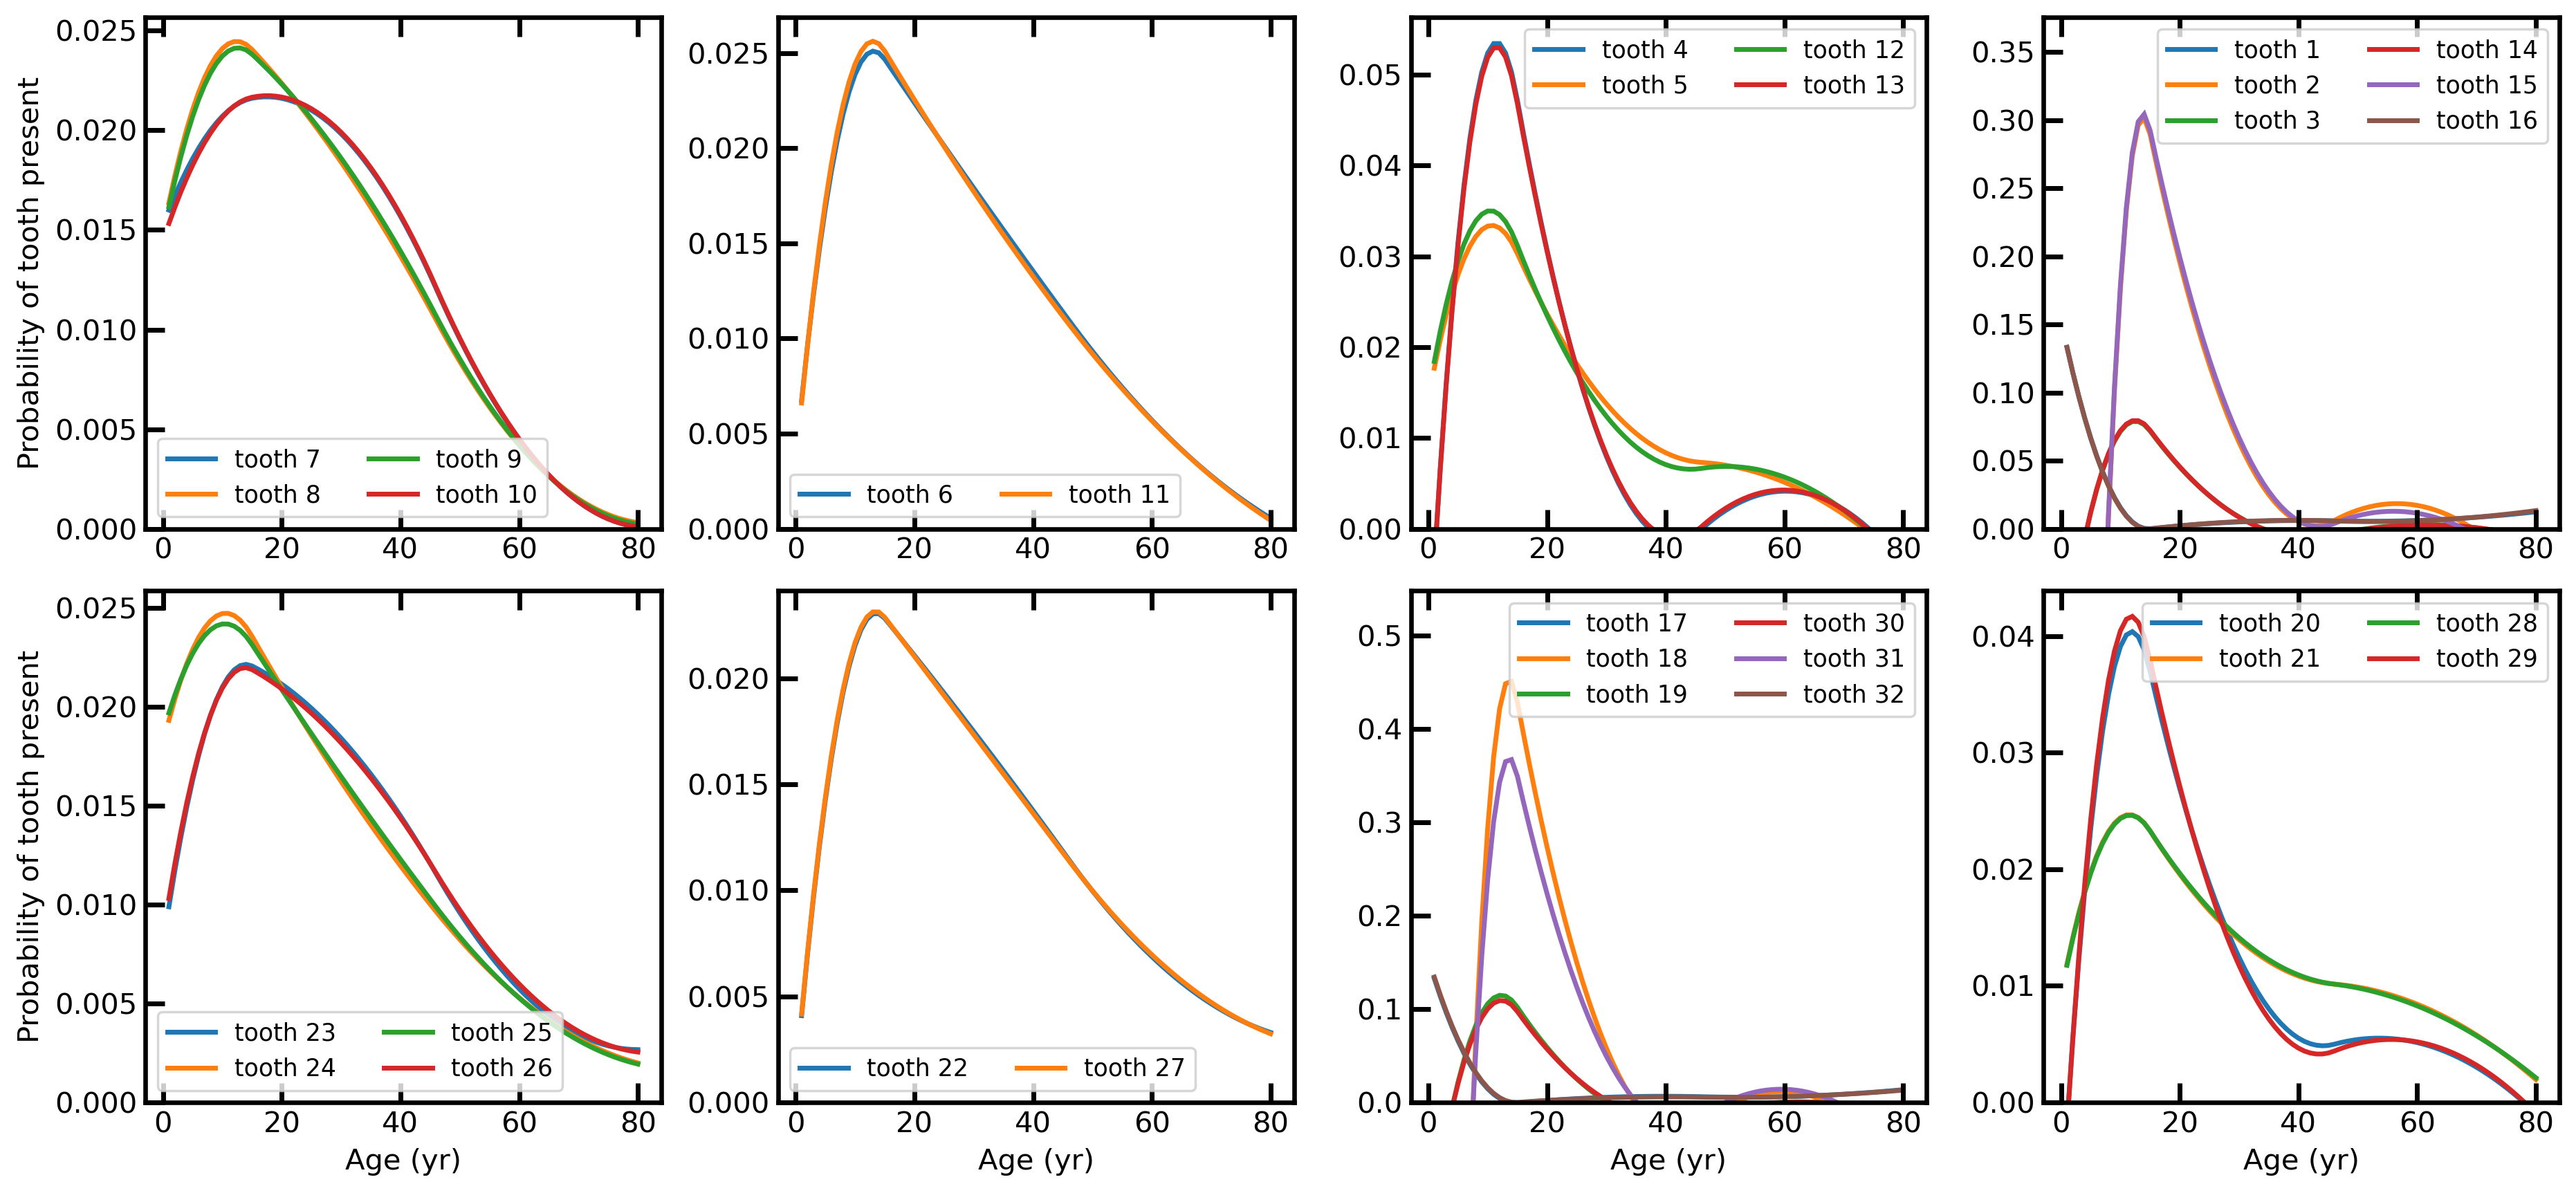

In [291]:
fig, axs = plt.subplots(2, 4, figsize=(15,7))

#Defining indices of upper and lower teeth and type
index_up_inc = np.array([7,8,9,10])
index_up_can = np.array([6,11])
index_up_premol = np.array([4,5,12,13])
index_up_molar = np.array([1,2,3,14,15,16])

index_low_inc = np.array([23,24,25,26])
index_low_can = np.array([22,27])
index_low_premol = np.array([17,18,19,30,31,32])
index_low_molar = np.array([20,21,28,29])

indices = np.array([[index_up_inc,index_up_can,index_up_premol,index_up_molar],
                    [index_low_inc,index_low_can,index_low_premol,index_low_molar]])
        

for i in range(2):
    axs[i,0].set_ylabel("Probability of tooth present")
    for j in range(4):
        labels = ["tooth "+str(i) for i in indices[i,j]]
        for k in range(len(indices[i,j])):
            axs[i,j].plot(df.iloc[ind].age, prob[:, indices[i,j][k]-1], label=labels[k])
        axs[i,j].set_ylim(bottom=0)
        axs[i,j].legend(ncol=2)
        axs[1,j].set_xlabel("Age (yr)")


plt.tight_layout()

**Figure 1**: Probability of having a given tooth as a function of age. Each column represetn a different type of tooth. From left to right: Incisors, canines, premolars and molars. The top row is for the upper teeth and the bottom row for lower teeth.

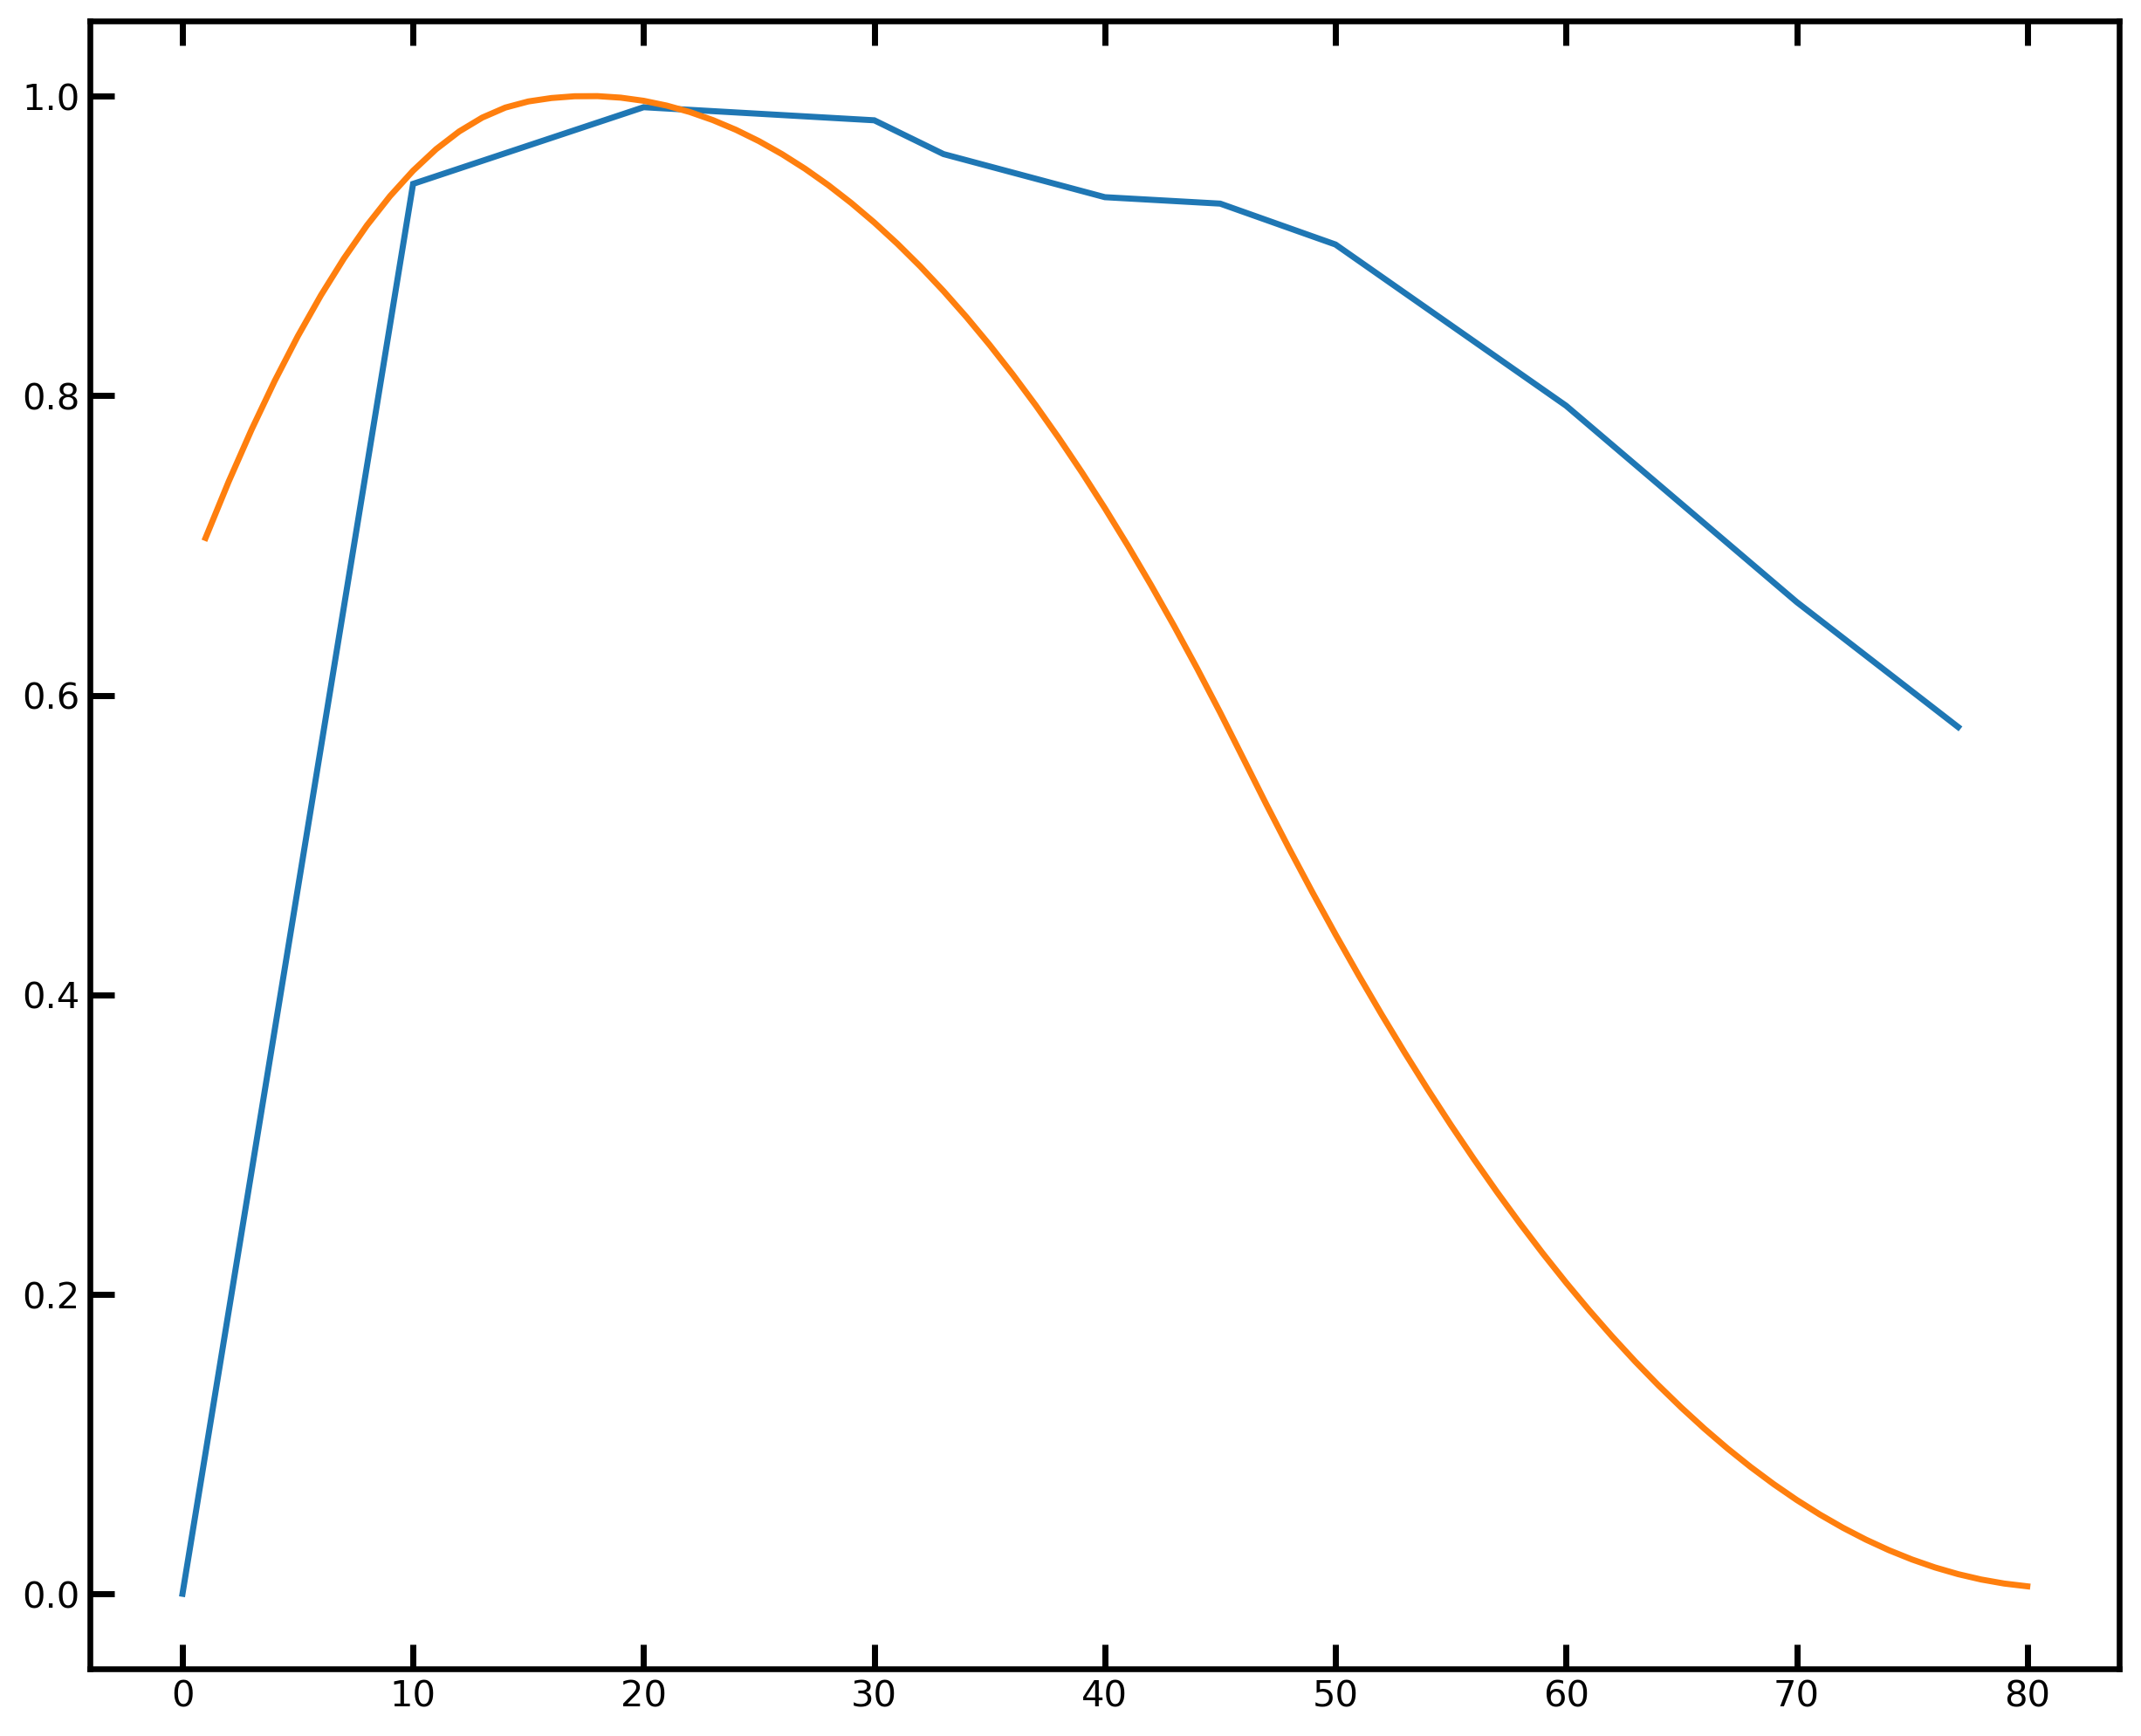

In [301]:
plt.plot(age_decils,emp_decils)
plt.plot(df.iloc[ind].age,prob[:,9]/prob[:,9].max())

In [293]:
empirical = np.zeros(ages.shape)
for i in range(len(ages)):
    aux[i] = df.query("tooth_10_C == 1").query("age=="+str(ages[i])).shape[0]/counts[i]
    
age_decils = np.array([0,10,20,30,33,40,45,50,60,70,77])
emp_decils = np.zeros(11)
for i in range(1,11):
    count_decil = df.query(str(age_decils[i-1])+"<age<"+str(age_decils[i])).shape[0]
    emp_decils[i] = df.query("tooth_10_C == 1").query(str(age_decils[i-1])+"<age<"+str(age_decils[i])).shape[0]/count_decil
    
    

# Question 2 - Hosmer-Lemeshow Calibration Plot